<div id="container" style="position:relative;">
<div style="float:left">

***Kazi Shahid***

***BrainStation Data Science Diploma Candidate***

***Capstone Project***

=============================================================

***Project SteamBuzz: Will Our Game Create a Buzz in the Steam community?***

***Part 4 (a): Sentiment Analysis ML Model 1 - Logistic Regression***
    
</div>
<div style="position:relative; float:right"><img style="height:100px" src ="https://i.ibb.co/mcvpL4Z/Steam-Buzz-logo.png" />
</div>
</div>

---
# Overview

In this part of the project, we will train a linear classifier on the data - the logistic regression.

Logistic regression is [defined](https://www.sciencedirect.com/topics/computer-science/logistic-regression) as a process of modelling the probability of a discrete outcome given an input variable. Most commonly, logistic regression classifiers model a binary outcome, i.e., outputs that constitute two unique values such as positive/negative, true/false, yes/no, etc.

Logistic regression is a relatively simple yet very effective algorithm to use when we need to take a fast pass at benchmarks (given the fact that it is more efficient than other ML Models, especially when the dataset is not massive) in relation to binary target variable, and investigate into feature importance, i.e., significance of predictors.

---
# Process Flow

The process flow for this part of the project is as follows:

1. Loading the dataset as was prepared and preprocessed in Part 3 of the project
2. Employing the classifier and optimizing its hyperparameters through Grid Search and cross validation
3. Choosing the parameter values for which the classifier performed the best and re-employing the classifier with the optimized hyperparameters
4. Evaluating the model using the appropriate performance measures
5. Derive any valuable insights from the model
6. Wrapping up with concluding remarks, summarizing the findings

In [1]:
# Importing the necessary data analysis and visualization toolkits
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

# To display ALL the columns in the dataframes
pd.options.display.max_columns=None

# To display a considerable extent (first 500 characters) of the content of each column of the dataframes
pd.set_option('display.max_colwidth', 100)

# Filtering out potential warnings
import warnings
warnings.filterwarnings('ignore')

---
# Loading the Training and Test Datasets

First, we load the X (features) and y (target) training and test datasets as cleaned up in Part 3 of the project, and check that their shapes to confirm that they loaded correctly.

In [2]:
# Importing the X_train, X_test, y_train, and y_test datasets from the respective pickle files into Pandas DataFrame forms
X_train = pd.read_pickle("data\\X_train.pkl")
X_test = pd.read_pickle("data\\X_test.pkl")
y_train = pd.read_pickle("data\y_train.pkl")
y_test = pd.read_pickle("data\y_test.pkl")

# Note: The destination paths above includes a duplicated backslash ("\\") rather than single ("\") as otherwise it shows the below error
# "SyntaxError: (unicode error) 'unicodeescape' codec can't decode bytes in position 4-5: truncated \xXX escape"
# This is because the "\x..." ("\x_train" in our case) starts an 8-character Unicode escape where digits follow the "\x"
# But in our case, digits do not follow the "\x..." ("\x_train" in our case), making the escape invalid and throwing an error
# This error has been resolved based on https://stackoverflow.com/a/1347854

In [3]:
# Checking that the datasets loaded correctly, displaying the shapes
## Displaying the dataframes themselves take a lot of time, hence choosing to display their shapes
print(f"Shape of X_train dataset: {X_train.shape}")
print(f"Shape of X_test dataset: {X_test.shape}")
print(f"Shape of y_train dataset: {y_train.shape}")
print(f"Shape of y_test dataset: {y_test.shape}")

Shape of X_train dataset: (55248, 7729)
Shape of X_test dataset: (13812, 7729)
Shape of y_train dataset: (55248,)
Shape of y_test dataset: (13812,)


We can see that the shapes above exactly match the final output of Part 3 of the project, so the datasets loaded correctly.

---
# Selection of Hyperparameters for Logistic Regression Classifier

A full list and description of the hyperparameters we can tune in a logistic regression model can be found in [its documentation](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html).

We will consider setting/tuning the three most impactful and important hyperparameters, all related to the 'Regularization' technique, as discussed below.

## Regularization

The 'Regularization' technique is implemented with a view to reducing overfitting in a model, by discouraging the model from taking an overly complex form. For our model, we will implement this technique by specifying its `solver` and `penalty` along with tuning the `C` parameter.

### Regularization Solver

We can use a few solver for regularization such as `newton-cg`, `lbfgs`, `liblinear`, `sag`, and `saga`.
- `newton-cg` is slow for large datasets as it computes the second partial derivatives (Hessian Matrix)
- For small datasets, `liblinear` is a good option, however is known to get stuck at a non-stationary point (i.e. non-optima)  and cannot run in parallel
- `sag` and `saga` are faster for large datasets, but sometimes impractical for large N
- `lbfgs` is most popular (it was set as the default solver in version 0.22) and can handle large datasets

We selected the **`lbfgs`** solver for our classifier as we are training our model on a very large dataset where the other solvers are not likely to perform well as evident from the above.

### Regularization Penalty Type

The options here are `l1`, `l2`, `elasticnet`, and `none`.

According to the documentation: *["The ‘newton-cg’, ‘sag’, and ‘lbfgs’ solvers support only L2 regularization with primal formulation, or no regularization."](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html)*. Therefore, we have selected **`l2`** to go with `lbfgs` as the solver selected for our logistic regression.

### Regularization Penalty Strength

The `C` regularization hyperparameter controls how closely the logistic regression model will fit to the training data by setting the penalty strength. The default setting is `C=1` but it is necessary to tune this hyperparameter to see at which point the model performs the best.

When setting the `C` value for the model, we need to keep in mind that:
- The level of regularization actually goes in the opposite direction of the value of `C`, i.e., the higher the `C` value, the lower the regularization (this is because C=1/λ where λ is the original hyperparameter proportional to the level of regularization).
- Setting `C` value too high will cause the model to overfit. On the other hand, setting it too low will cause the model to underfit.

Therefore, for our model, we will cycle through a range of `C` values (e.g., **`C = 0.0001, 0.001, 0.01, 0.1, 1, 10, 100`** etc.) to find a general optimum point between where the model neither overfits nor underfits.

---
# Employing Logistic Regression Classifier

We now employ our logistic regression classifier. First, we will instantiate a classifier object, then optimize the hyperparameter using `GridSearchCV` and cross validation. Finally, we will re-employ the classifier with the hyperparameter values with which the classifier performed the best.


## Instantiating a Logistic Regression Object

We start by instantiating a logistic regression object for our modelling. Here, we set two of the hyperparameters in line with our [hyperparameter selection section above](#Regularization) that we do not need to iterate through to optimize.

In [5]:
# Importing linear_model class from scikit-learn library
from sklearn import linear_model

# Instantiating a logistic regression object for our modelling
## Setting solver to 'lbfgs' and penalty to 'l2' as discussed and selected
logreg = linear_model.LogisticRegression(solver='lbfgs', penalty='l2')

## Hyperparameter Setup

We are defining the hyperparameters that we are looking to optimize for our linear classifier which, for our dataset, is only the `C` parameter as discussed in the [hyperparameter selection section above](#Selection-of-Hyperparameters-for-Logistic-Regression-Classifier). We will take a range of values to iterate through and set them as such: `C = 0.0001, 0.001, 0.01, 0.1, 1, 10, 100`.

In [11]:
# Setting hyperparameter values to iterate through and optimize
C_values = np.asarray([0.0001, 0.001, 0.01, 0.1, 1, 10, 100])

## GridSearchCV Setup

Now we will set up the `GridSearchCV` with the appropriate values.

In [61]:
# Importing GridSearchCV from scikit-learn library's model_selection module
from sklearn.model_selection import GridSearchCV

In [13]:
# Creating a logistic regression object for GridSearchCV
## We ask the GridSearchCV to iterate through the 'C' parameter values we set above (C_values)
## We set the cross validation fold to 5
logreg_gs = GridSearchCV(logreg, {'C': C_values}, cv=5)

## Hyperparameter Optimization

Now we will optimize the hyperparameters by iterating through the parameter values, testing via cross validation, and checking the results with which the classifier performed the best.

In [14]:
# Fitting the train datasets
logreg_gs.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=LogisticRegression(),
             param_grid={'C': array([1.e-04, 1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02])})

In [60]:
# Storing the fitted model's results (will be used in deriving model insights in a later section further below)
result = logreg_gs.fit(X_train, y_train)

In [19]:
print(f"The model performs the best at a C-value of {logreg_gs.best_estimator_.get_params()['C']}")

The model performs the best at a C-value of 1.0


## Best Logistic Regression Model with Optimized Hyperparameter

We observed that the 5-fold cross validation determined the model performing the best at a `C` value of 1.0. We will set `C=1.0` and run the model to evaluate it.

In [7]:
# Instantiating a logistic regression object for this model with the best parameters
logreg_best = linear_model.LogisticRegression(C=1.0, solver='lbfgs', penalty='l2')

In [8]:
# Importing time module
import time
t1 = time.perf_counter() # Track start time of running this cell

# Fitting to the train datasets with the optimum hyperparameters for this model
logreg_best.fit(X_train, y_train);

t2 = time.perf_counter() # Track end time of running this cell
print(f"Execution time: {round(t2-t1)} seconds") # Show execution time

Execution time: 69 seconds


We can see that the logistic regression model fits very fast, taking only 69 seconds in the local machine.

---
# Model Evaluation

We will now evaluate how well the logistic regression model learned from the input variables, by measuring how well it is able to predict the output values.

## Accuracy Scores

Accuracy is defined as the proportion of examples for which the model produces the correct output. We will calculate this measure now.

In [40]:
# Accuracy scores of the train and test models
print(f"Accuracy score of the Train model: {round(logreg_best.score(X_train, y_train)*100,4)}%")
print(f"Accuracy score of the Test model: {round(logreg_best.score(X_test, y_test)*100,4)}%")

Accuracy score of the Train model: 87.4584%
Accuracy score of the Test model: 85.4909%


This is a great result in the sense that:
- The accuracy scores are quite high (mid-to-high 80%s), and
- The difference between the train and test model accuracy scores are very small (less than 2%), indicating that the model is generalizing very well.

However, as discussed before, accuracy scores give a high-level, general indication. We need to go beyond accuracy scores and look into the model's confusion matrix to get a better idea of how well the model is actually performing. Although, based on the fact that the dataset is perfectly balanced between the two classes, we can expect the accuracy score to be a quite reliable measure - we can confirm this based on the next performance measures.

## Confusion Matrix

A [confusion matrix](https://machinelearningmastery.com/confusion-matrix-machine-learning/#:~:text=A%20confusion%20matrix%20is%20a%20summary%20of%20prediction%20results%20on,key%20to%20the%20confusion%20matrix.) (aka "error matrix") is a summary of prediction results on a classification problem. The number of correct and incorrect predictions are summarized with count values and broken down by each class.

Generating the confusion matrix for the model:

In [9]:
# Import confusion matrix
from sklearn.metrics import plot_confusion_matrix, confusion_matrix

In [13]:
# Generating class predictions
y_pred = logreg_best.predict(X_test)

# Creating the confusion matrix
cf_matrix = confusion_matrix(y_test, y_pred)

# Specifying confusion matrix rows and columns labels
cf_df = pd.DataFrame(
    cf_matrix, 
    columns=["Predicted negative (0) rating", "Predicted positive (1) rating"],
    index=["True negative (0) rating", "True positive (1) rating"]
)

display(cf_df)

,Predicted negative (0) rating,Predicted positive (1) rating
True negative (0) rating,5878,968
True positive (1) rating,1036,5930


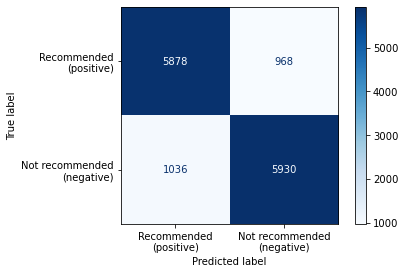

In [11]:
# Specifying class labels to show in the confusion matrix axes
classes = ['Recommended\n(positive)', 'Not recommended\n(negative)']

# Plotting confusion matrix, setting the expected estimator, inputs and target as parameters
## Displaying class labels on the axes
## Setting colour map to "Blues" to be in line with the Steam platform colour scheme throughout the project
## Passing values_format as '', otherwise it displays in scientific notation (e.g., "5878" is displayed as 5.878e3 which may be confusing for readers)
plot_confusion_matrix(logreg_best, X_test, y_test,
                      display_labels=classes,
                      cmap=plt.cm.Blues,
                      values_format = '');

As we can see from the above confusion matrix:
- **True Positive** ("TP") quadrant (top-left box): The model predicted 5,878 positive ratings which were truly positive ratings, i.e., 5,878 **accurate** predictions of **"positive"** ratings.


- **False Negative** ("FN") quadrant (top-right box): The model predicted 968 negative ratings which were actually positive ratings, i.e., 968 **inaccurate** predictions of **"negative"** ratings.


- **False Positive** ("FP") quadrant (bottom-left box): The model predicted 1,036 positive ratings which were actually negative ratings, i.e., 1,036 **inaccurate** predictions of **"positive"** ratings.


- **True Negative** ("TN") quadrant (bottom-right box): The model predicted 5,930 negative ratings which were truly negative ratings, i.e., 5,930 **accurate** predictions of **"negative"** ratings.

This is a better measure of the model's performance than accuracy score, as it paints a more in-depth picture of how many accurate and inaccurate predictions were made by the model. This paves the way to introducing 'Precision' and 'Recall' as performance measures.

## Precision

**Precision** measures the proportion of positive identifications that were actually correct.

In formulaic expression:

$$Precision = \frac{TP}{TP+FP}$$

Now, calculating the precision for our model -

In [14]:
# Importing precision score module
from sklearn.metrics import precision_score

# Calculating precision score for ML Model #3-d
print(f"Precision of the model: {round(precision_score(y_test, y_pred)*100, 2)}%")

Precision of the model: 85.97%


This is a great result in the sense that, of all the reviews that were predicted as positive plus the reviews that were actually positive, the model **accurately predicted the positive reviews about 86% of the time**.

## Recall

**Recall** measures the proportion of actual positives that were identified correctly.

In formulaic expression:

$$Recall = \frac{TP}{TP+FN}$$

Now, calculating the recall for our model -

In [15]:
# Recall
from sklearn.metrics import recall_score

# Calculating recall score for ML Model #3-d
print(f"Recall: {round(recall_score(y_test, y_pred)*100, 2)}%")

Recall: 85.13%


This is also a great result. This means that of all the reviews that were actually positive, **the model accurately predicted the positive reviews more than 85% of the time**.

## F1-Score

The F1-score is another popular accuracy measure, which balances the precision and recall measures. F1-score is the harmonic mean of the precision and recall scores, calculated as follows:

$$F_1 = 2 \cdot \frac{precision \cdot recall}{precision + recall}$$

Now, calculating the F1-score for our model -

In [16]:
# Recall
from sklearn.metrics import f1_score

# Calculating recall score for ML Model #3-d
print(f"F1 Score: {round(f1_score(y_test, y_pred)*100, 2)}%")

F1 Score: 85.55%


This is another great result as portrayed by the harmonic mean (balance) of the precision and recall measures, signifying that the model accurately predicts the outcome of the review texts about 86% of the time.

## ROC AUC

The Receiver Operating Characteristic (ROC) curve is formed by plotting the [true positive rate (TPR)](https://www.split.io/glossary/false-positive-rate/#:~:text=The%20true%20positive%20rate%20(TPR,as%20TN%2FTN%2BFP.) against the [false positive rate (FPR)](https://www.ibm.com/support/producthub/icpdata/docs/content/SSQNUZ_latest/wsj/model/wos-quality-fpr.html). The area under the ROC curve (AUC) is an associated metric that represents, after plotting the ROC curve, the measure of the area under the curve.

Now, calculating the ROC AUC score for our model -

In [17]:
# Recall
from sklearn.metrics import roc_auc_score

# Calculating recall score for ML Model #3-d
print(f"ROC AUC Score: {round(roc_auc_score(y_test, y_pred)*100, 2)}%")

ROC AUC Score: 85.49%


This score signifies that the model is capable of accurately distinguishing between the two outcome classes more than 85% of the time; i.e., when a review text is passed through the model, it is able to accurately separate the positive-sentiment reviews from the negative-sentiment ones accurately more than 85% of the time.

Now, when plotting the curve, we find the following:

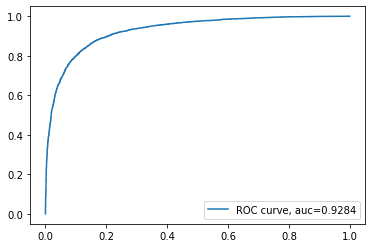

In [19]:
# Importing metrics from scikit-learn library
from sklearn import metrics

# Plotting the ROC AUC curve

## Calculating probability of predicting outcome variable classes and plotting the ROC AUC curve
y_pred_probab = logreg_best.predict_proba(X_test)[::,1]
fpr, tpr, _ = metrics.roc_curve(y_test,  y_pred_probab)
auc = metrics.roc_auc_score(y_test, y_pred_probab)
plt.plot(fpr, tpr, label="ROC curve, auc="+str(round(auc,4)))
plt.legend(loc=4)
plt.show()

We see in the plot that the area under the curve is about 93%. This implies that, when the model is presented with two random reviews, one from the positive-review class and one from the negative-review class, it is more confident that the positive point belongs to the positive class than the negative point belonging to the positive class.

---
# Model Insights

Now that we have found out that the logistic regression model is performing fantastically in accurately predicting the positive and negative classes, we can confidently attempt to derive some insights from this model.

In [36]:
# Creating a dataframe after extracting the intercept and coefficients of the model, and transposing to convert to column
coeff = pd.DataFrame(logreg_best.coef_, logreg_best.intercept_)

# Converting the column names from column index into actual column names
coeff.columns = X_train.columns

# Printing column names
print(f"Column names for the coefficient dataframe: {coeff.columns}")

Column names for the coefficient dataframe: Index(['char_len_transformed', 'title_100% Orange Juice',
       'title_Act of Aggression - Reboot Edition',
       'title_Age of Empires II HD',
       'title_Age of Mythology: Extended Edition', 'title_Age of Wonders III',
       'title_Anno 2070(tm)', 'title_Anno 2205(tm)',
       'title_Arma 2: Operation Arrowhead', 'title_Arma 3',
       ...
       'zelda', 'zen', 'zerg', 'zero', 'zeus', 'zip', 'zombi', 'zone', 'zoo',
       'zoom'],
      dtype='object', length=7729)


We can see that (and also recalling from Part 3 of the project where we created the final dataset for feeding into the ML models) the columns are primarily of three types:
- Character length of review text
- Game titles
- Vectorized review texts

We will create coefficients-dataframes for each of these three buckets so that we can look at the coefficients from these three perspectives in order to derive insights from these angles.

In [30]:
# First, dropping the character length coefficient column for use in the two other buckets
coeff2 = coeff[coeff.columns.drop(list(coeff.filter(regex='char_len')))]

In [42]:
# Now, creating coefficient dataframe for game titles
coeff_title = coeff2.loc[:, coeff2.columns.str.startswith('title')]

# Printing column names for the review-text-coefficient dataframe
print(f"Column names for the game-title coefficient dataframe: {coeff_title.columns}")

Column names for the game-title coefficient dataframe: Index(['title_100% Orange Juice', 'title_Act of Aggression - Reboot Edition',
       'title_Age of Empires II HD',
       'title_Age of Mythology: Extended Edition', 'title_Age of Wonders III',
       'title_Anno 2070(tm)', 'title_Anno 2205(tm)',
       'title_Arma 2: Operation Arrowhead', 'title_Arma 3',
       'title_Awesomenauts',
       ...
       'title_WAKFU', 'title_War for the Overworld',
       'title_Wargame: Airland Battle', 'title_Wargame: Red Dragon',
       'title_Warhammer 40000: Dawn of War II: Retribution',
       'title_Warhammer(r) 40000(tm): Dawn of War(r) II',
       'title_Wasteland 2: Directors Cut', 'title_XCOM(r) 2',
       'title_XCOM: Enemy Unknown', 'title_Yet Another Zombie Defense'],
      dtype='object', length=139)


## Top 20 Most Sentiment-predictive Words

First, we will create coefficient-dataframe for review text.

In [43]:
# Creating coefficient dataframe for review text
coeff_text = coeff2[coeff2.columns.drop(list(coeff2.filter(regex='title')))]

# Printing column names for the review-text coefficient dataframe
print(f"Column names for the review-text coefficient dataframe: {coeff_text.columns}")

Column names for the review-text coefficient dataframe: Index(['00', '000', '01', '010', '019', '02', '05', '06', '099', '10',
       ...
       'zelda', 'zen', 'zerg', 'zero', 'zeus', 'zip', 'zombi', 'zone', 'zoo',
       'zoom'],
      dtype='object', length=7589)


In [44]:
# Transposing the review-text coefficient so that the previously-column-names becomes the row index and the first column represents the coefficients
coeff_text = coeff_text.transpose()

# Changing column name from the intercept value to 'coeff'
coeff_text.set_axis(['coeff'], axis=1, inplace=True)

### Positive Sentiment-predictive Words

Now we will check which 30 words were most predictive of positive sentiment:

In [47]:
# Sorting the coefficients in descending order and taking the top 30
coeff_text_top30 = coeff_text.sort_values(by='coeff', ascending=False).head(30).reset_index()

<function matplotlib.pyplot.show(close=None, block=None)>

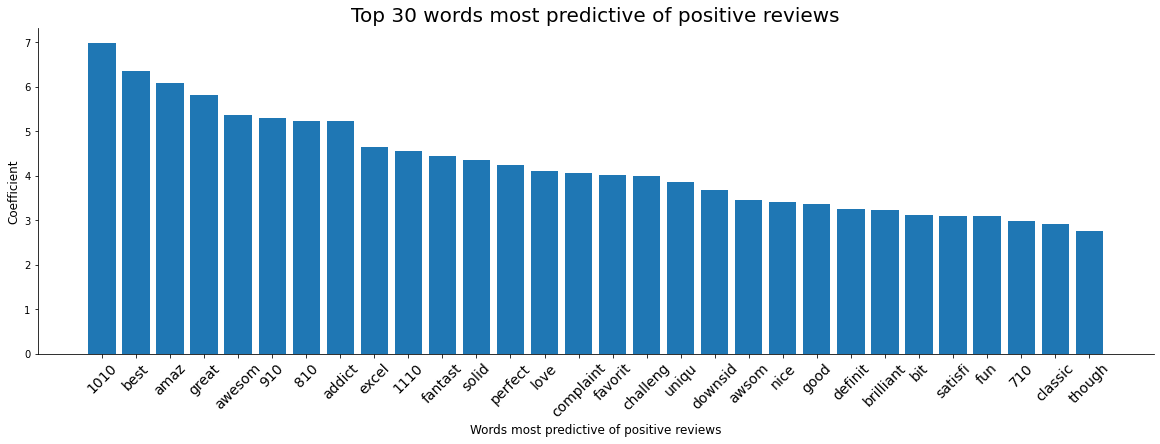

In [48]:
# Plotting the top 30 words predictive of positive reviews in a bar chart
plt.figure(figsize=(20, 6))
plt.bar(coeff_text_top30['index'], coeff_text_top30['coeff'])
plt.xlabel('Words most predictive of positive reviews', fontsize=12)
plt.ylabel('Coefficient', fontsize=12)
plt.xticks(rotation=45, fontsize=14)
plt.title("Top 30 words most predictive of positive reviews", fontsize=20)
sns.despine()
plt.show

We can see from the above that the top 30 words most predictive of positive sentiment:
- Did not provide much of an insight as they included rather generic positive-sentiment-expressing words such as "best", "amazing", "great", "awesome", etc.
- Included a few numeric strings such as "1010", "910", "810", "1110" and "710". These are also not insightful as they clearly refers to numerical rating that the reviewer gave the game in text: "10/10", "9/10", "8/10", "11/10", "7/10", etc.
- A couple of words that may have been valuable were "challenging" and "addictive", referring to gameplay experience that the reviewers liked and perhaps we can consider pondering if our game lacks challenging and/or addictive gameplay elements.

We perhaps need to consider look into doing N-grams to generate some insightful set of words.

### Negative Sentiment-predictive Words

Now, we move on to the top 30 words most predictive of negative sentiment to see if we find any insights from there:

In [51]:
# Sorting the coefficients in ascending order and taking the top 30 (i.e., bottom 30 if was in descending order)
coeff_text_bottom30 = coeff_text.sort_values(by='coeff', ascending=True).head(30).reset_index()

<function matplotlib.pyplot.show(close=None, block=None)>

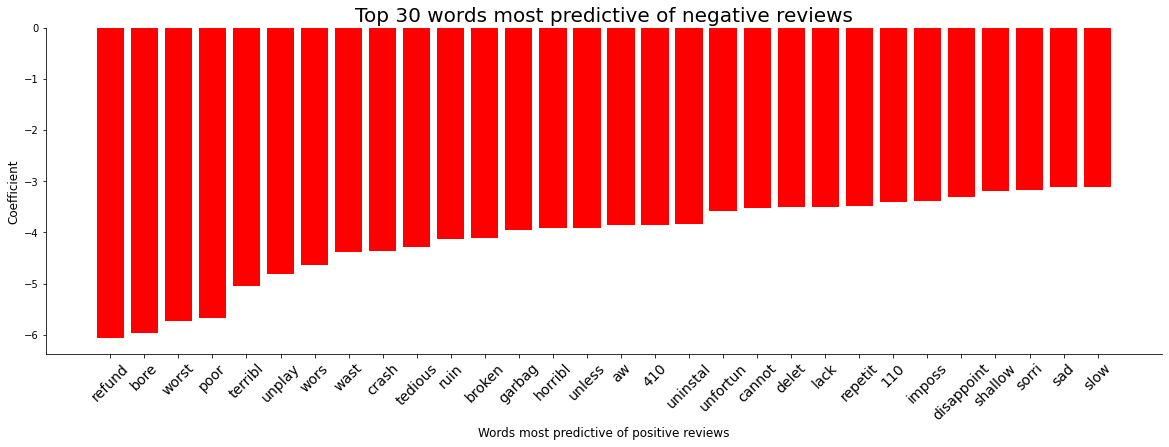

In [52]:
# Plotting the top 30 words predictive of positive reviews in a bar chart
plt.figure(figsize=(20, 6))
plt.bar(coeff_text_bottom30['index'], coeff_text_bottom30['coeff'], color='red')
plt.xlabel('Words most predictive of positive reviews', fontsize=12)
plt.ylabel('Coefficient', fontsize=12)
plt.xticks(rotation=45, fontsize=14)
plt.title("Top 30 words most predictive of negative reviews", fontsize=20)
sns.despine()
plt.show

Amidst the rather generic positive-sentiment-expressing words such as "worst", "poor", "terrible", "unplayable", etc., we see a few insightful words:

- "crash" and "broken", likely pointing to the game crashing that caused frustration to the reviewer. We need to ensure our game does not have any bugs that may cause it to crash.
- "repetitive", which cautions us that our gameplay elements, stories, character arcs (if any) etc. do not come across as repetitive to the gamers.
- "shallow", likely pointing to a shallow storyline, character arc, or even gameplay elements/experience, which we may need to be aware of in relation to our game.
- "slow", which can be tied to the "addictive" and "challenging" words we found above that were predictive of positive sentiments. We need to ensure that the gamer does not find our game slow but rather fast-paced and challenging.

## Top 20 Most Positive/Negative-experience Inducing Games

Now we look into which games generated the most positive or negative sentiment among the reviewers.

In [57]:
# Transposing the review-text coefficient so that the previously-column-names becomes the row index and the first column represents the coefficients
coeff_title = coeff_title.transpose()

# Changing column name from the intercept value to 'coeff'
coeff_title.set_axis(['coeff'], axis=1, inplace=True)

### Top 20 Most Positively-received Games

Plotting the top 20 games that generated the most positive sentiment:

In [93]:
# Sorting the coefficients in descending order and taking the top 20
coeff_title_top20 = coeff_title.sort_values(by='coeff', ascending=False).head(20).reset_index()

# Reversing the order (making ascending order) otherwise the next plot sorts in ascending order
coeff_title_top20 = coeff_title_top20.sort_values(by='coeff', ascending=True)

<function matplotlib.pyplot.show(close=None, block=None)>

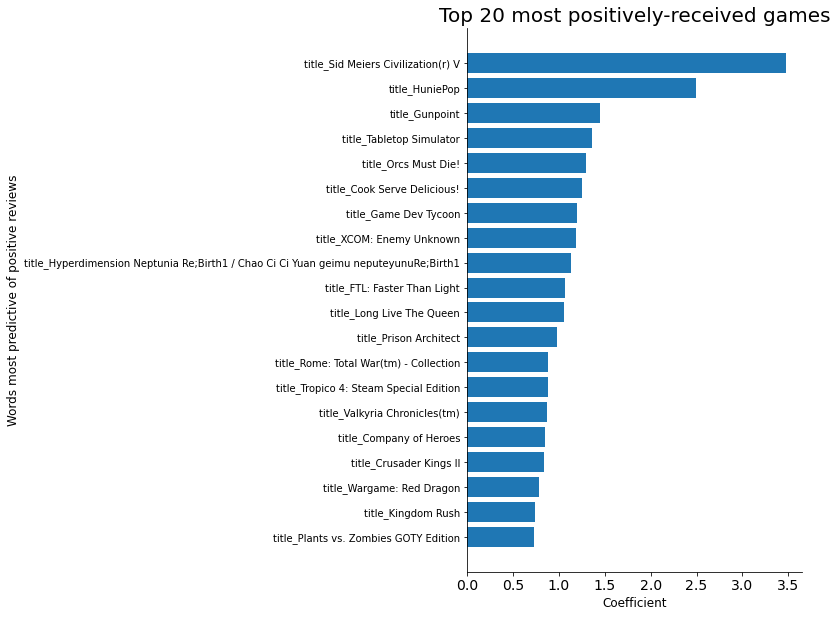

In [94]:
# Plotting the top 20 games that generated the most positive sentiment
plt.figure(figsize=(6, 10))
plt.barh(coeff_title_top20['index'], coeff_title_top20['coeff'])
plt.xlabel('Coefficient', fontsize=12)
plt.ylabel('Words most predictive of positive reviews', fontsize=12)
plt.xticks(fontsize=14)
plt.title("Top 20 most positively-received games", fontsize=20)
sns.despine()
plt.show

This is an important insight. We can check the top games and identify the ones that align closely with our game in terms of gameplay elements and experience, and check how close ours are to these. The closer our game's gameplay elements are to these, we can say that, implicitly, the higher the probability that our game will also be positively received.

### Top 20 Negatively-received Games

Plotting the top 20 games that generated negative sentiment most often:

In [104]:
# Sorting the coefficients in ascending order and taking the top 20
coeff_title_bottom20 = coeff_title.sort_values(by='coeff', ascending=True).head(20).reset_index()

# Reversing the order (making descending order) otherwise the next plot sorts in ascending order
coeff_title_bottom20 = coeff_title_bottom20.sort_values(by='coeff', ascending=False)

<function matplotlib.pyplot.show(close=None, block=None)>

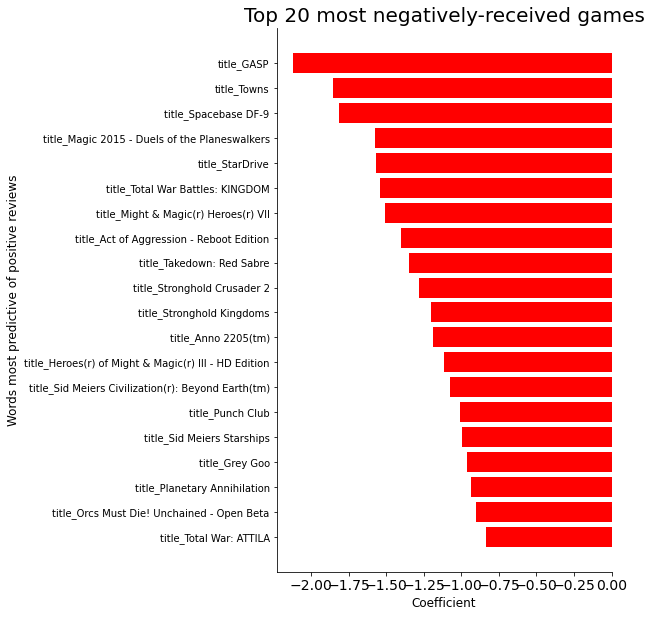

In [105]:
# Plotting the top 20 games that generated the most negative sentiment
plt.figure(figsize=(6, 10))
plt.barh(coeff_title_bottom20['index'], coeff_title_bottom20['coeff'], color='red')
plt.xlabel('Coefficient', fontsize=12)
plt.ylabel('Words most predictive of positive reviews', fontsize=12)
plt.xticks(fontsize=14)
plt.title("Top 20 most negatively-received games", fontsize=20)
sns.despine()
plt.show

Hand in hand with the plot above this, this is another important insight in the way that we should check these bottom-of-the-barrel games (in terms of review sentiment) and identify the ones that have gameplay elements and experience that may be in common with our game. The closer our game's gameplay elements are to these, we can say that, implicitly, the higher the probability that our game will also be negatively received.

---
# Conclusion

We can confidently conclude that this model performed fantastically as we have observed:
- [Very high train and test accuracy scores](#Accuracy-Scores) (both over 85%)
- [Very small difference between the train and test accuracy scores](#Accuracy-Scores) (less than 2% difference between the two scores)
- Very high [precision](#Precision), [recall](#Recall), [F1](#F1-Score) as well as [ROC AUC scores](#ROC-AUC) (all above 85%)

Statistically speaking, if we had to blindly guess the class (positive/negative) for a review, we would have been expected to be correct about 50% of the time (as the dataset's class distribution is 50/50). From this standpoint, this ML model has **added significant value by adding a substantial (more than 35%) increase in accuracy** in predicting the classes based on input values.

For quick reference, the accuracy, precision, recall, and F1 scores are also summarized and tabulated below:

In [63]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

print(confusion_matrix(y_test,y_pred))
print(classification_report(y_test,y_pred))
print(accuracy_score(y_test, y_pred))

[[5878  968]
 [1036 5930]]
              precision    recall  f1-score   support

           0       0.85      0.86      0.85      6846
           1       0.86      0.85      0.86      6966

    accuracy                           0.85     13812
   macro avg       0.85      0.85      0.85     13812
weighted avg       0.85      0.85      0.85     13812

0.8549087749782798


In [108]:
# Saving the best model locally for retrieval in later part of the project as needed

## Importing pickle
import pickle

## Saving the model locally
pickle.dump(logreg_best, open('model1_logreg_final.sav', 'wb'))